<a href="https://colab.research.google.com/github/kridtapon/SureSignal-MACD/blob/main/SureSignal_MACD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate KST (Know Sure Thing)
def calculate_kst(data, r1=10, r2=15, r3=20, r4=30, sm1=10, sm2=10, sm3=10, sm4=15, signal_period=9):
    """
    Calculate the Know Sure Thing (KST) indicator.
    """
    roc1 = data['Close'].pct_change(r1) * 100
    roc2 = data['Close'].pct_change(r2) * 100
    roc3 = data['Close'].pct_change(r3) * 100
    roc4 = data['Close'].pct_change(r4) * 100

    kst = (roc1.rolling(sm1).mean() +
           roc2.rolling(sm2).mean() * 2 +
           roc3.rolling(sm3).mean() * 3 +
           roc4.rolling(sm4).mean() * 4)

    signal = kst.rolling(signal_period).mean()
    return kst, signal

# Function to calculate MACD
def calculate_macd(data, fast=12, slow=26, signal_period=9):
    """
    Calculate the MACD indicator.
    """
    ema_fast = data['Close'].ewm(span=fast, min_periods=1).mean()
    ema_slow = data['Close'].ewm(span=slow, min_periods=1).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, min_periods=1).mean()
    return macd, signal

# Define the stock symbol and time period
symbol = 'GDDY'  #BTC-USD KKR GDDY HWM
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate MACD and KST indicators
df['MACD'], df['MACD_Signal'] = calculate_macd(df)
df['KST'], df['KST_Signal'] = calculate_kst(df)

# Define Entry and Exit signals based on MACD and KST
df['Entry'] = (df['MACD'] > df['MACD_Signal']) & (df['KST'] > df['KST_Signal'])
df['Exit'] = (df['MACD'] < df['MACD_Signal']) & (df['KST'] < df['KST_Signal'])

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           112045.955102
Total Return [%]                        12.045955
Benchmark Return [%]                    72.463099
Max Gross Exposure [%]                      100.0
Total Fees Paid                       8150.181193
Max Drawdown [%]                         17.04093
Max Drawdown Duration                       708.0
Total Trades                                   36
Total Closed Trades                            36
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            44.444444
Best Trade [%]                          10.734697
Worst Trade [%]                         -4.742668
Avg Winning Trade [%]                    4.211314
Avg Losing Trade [%]                    -2.647243


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Ensure signal_period is cast to an integer before passing it to the rolling method
def calculate_kst(data, r1=10, r2=15, r3=20, r4=30, sm1=10, sm2=10, sm3=10, sm4=15, signal_period=9):
    """
    Calculate the Know Sure Thing (KST) indicator.
    """
    roc1 = data['Close'].pct_change(r1) * 100
    roc2 = data['Close'].pct_change(r2) * 100
    roc3 = data['Close'].pct_change(r3) * 100
    roc4 = data['Close'].pct_change(r4) * 100

    # Rolling mean calculations with integer window sizes
    kst = (roc1.rolling(int(sm1)).mean() +
           roc2.rolling(int(sm2)).mean() * 2 +
           roc3.rolling(int(sm3)).mean() * 3 +
           roc4.rolling(int(sm4)).mean() * 4)

    signal = kst.rolling(int(signal_period)).mean()
    return kst, signal

# Function to calculate MACD
def calculate_macd(data, fast=12, slow=26, signal_period=9):
    ema_fast = data['Close'].ewm(span=fast, min_periods=1).mean()
    ema_slow = data['Close'].ewm(span=slow, min_periods=1).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, min_periods=1).mean()
    return macd, signal

# Define the stock symbol and time period
symbol = 'GDDY'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Parameter grids for optimization
macd_fast_grid = range(5, 15, 2)
macd_slow_grid = range(15, 31, 2)
macd_signal_grid = range(5, 31, 2)
kst_signal_grid = range(5, 31, 2)

# Generate all parameter combinations
param_combinations = list(product(macd_fast_grid, macd_slow_grid, macd_signal_grid, kst_signal_grid))

# Store results
results = []

# Loop through parameter combinations
for macd_fast, macd_slow, macd_signal, kst_signal in param_combinations:
    # Calculate indicators
    df['MACD'], df['MACD_Signal'] = calculate_macd(df, fast=macd_fast, slow=macd_slow, signal_period=macd_signal)
    df['KST'], df['KST_Signal'] = calculate_kst(df, signal_period=kst_signal)

    # Define Entry and Exit signals
    df['Entry'] = (df['MACD'] > df['MACD_Signal']) & (df['KST'] > df['KST_Signal'])
    df['Exit'] = (df['MACD'] < df['MACD_Signal']) & (df['KST'] < df['KST_Signal'])

    # Filter data for the test period (2020-2025)
    df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=df['Entry'],
        exits=df['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    stats = portfolio.stats()
    total_return = stats.loc['Total Return [%]']

    results.append((macd_fast, macd_slow, macd_signal, kst_signal, total_return))

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results, columns=['MACD_Fast', 'MACD_Slow', 'MACD_Signal', 'KST_Signal', 'Total_Return'])

# Find the best parameters by Total Return
best_params = results_df.sort_values('Total_Return', ascending=False).iloc[0]
print("Best Parameters:")
print(best_params)

# Plot the best strategy
best_macd_fast = best_params['MACD_Fast']
best_macd_slow = best_params['MACD_Slow']
best_macd_signal = best_params['MACD_Signal']
best_kst_signal = best_params['KST_Signal']

df['MACD'], df['MACD_Signal'] = calculate_macd(df, fast=best_macd_fast, slow=best_macd_slow, signal_period=best_macd_signal)
df['KST'], df['KST_Signal'] = calculate_kst(df, signal_period=best_kst_signal)
df['Entry'] = (df['MACD'] > df['MACD_Signal']) & (df['KST'] > df['KST_Signal'])
df['Exit'] = (df['MACD'] < df['MACD_Signal']) & (df['KST'] < df['KST_Signal'])

portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

portfolio.plot().show()

# Display performance metrics
print(portfolio.stats())


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Best Parameters:
MACD_Fast        13.0000
MACD_Slow        17.0000
MACD_Signal       9.0000
KST_Signal        5.0000
Total_Return    205.4655
Name: 5603, dtype: float64


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           305465.500143
Total Return [%]                         205.4655
Benchmark Return [%]                   187.879233
Max Gross Exposure [%]                      100.0
Total Fees Paid                      12281.362012
Max Drawdown [%]                        23.270906
Max Drawdown Duration                       450.0
Total Trades                                   33
Total Closed Trades                            33
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            45.454545
Best Trade [%]                          28.101588
Worst Trade [%]                        -10.027117
Avg Winning Trade [%]                   12.048295
Avg Losing Trade [%]                       -2.922


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



[*********************100%***********************]  1 of 1 completed


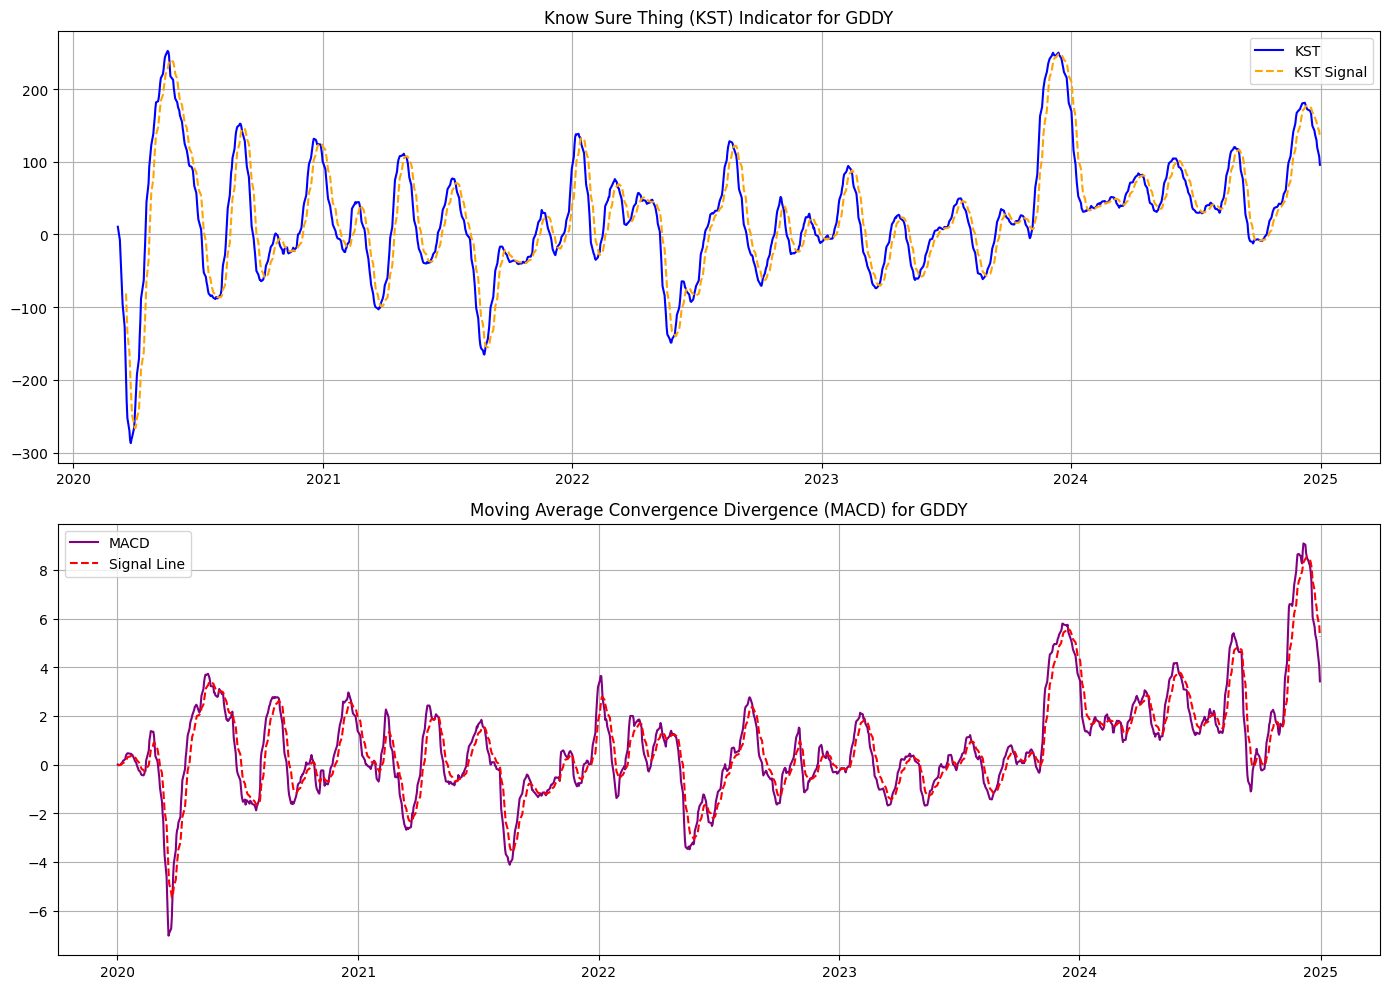

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf

# Define the stock symbol and time period
symbol = 'GDDY'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df.ffill(inplace=True)

# Ensure signal_period is cast to an integer before passing it to the rolling method
def calculate_kst(data, r1=10, r2=15, r3=20, r4=30, sm1=10, sm2=10, sm3=10, sm4=15, signal_period=9):
    """
    Calculate the Know Sure Thing (KST) indicator.
    """
    roc1 = data['Close'].pct_change(r1) * 100
    roc2 = data['Close'].pct_change(r2) * 100
    roc3 = data['Close'].pct_change(r3) * 100
    roc4 = data['Close'].pct_change(r4) * 100

    # Rolling mean calculations with integer window sizes
    kst = (roc1.rolling(int(sm1)).mean() +
           roc2.rolling(int(sm2)).mean() * 2 +
           roc3.rolling(int(sm3)).mean() * 3 +
           roc4.rolling(int(sm4)).mean() * 4)

    signal = kst.rolling(int(signal_period)).mean()
    return kst, signal

# Function to calculate MACD
def calculate_macd(data, fast=12, slow=26, signal_period=9):
    ema_fast = data['Close'].ewm(span=fast, min_periods=1).mean()
    ema_slow = data['Close'].ewm(span=slow, min_periods=1).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, min_periods=1).mean()
    return macd, signal

# Calculate KST and MACD
kst, kst_signal = calculate_kst(df)
macd, macd_signal = calculate_macd(df)

# Plot the results
plt.figure(figsize=(14, 10))

# Plot KST
plt.subplot(2, 1, 1)
plt.plot(df.index, kst, label='KST', color='blue')
plt.plot(df.index, kst_signal, label='KST Signal', color='orange', linestyle='--')
plt.title(f'Know Sure Thing (KST) Indicator for {symbol}')
plt.legend()
plt.grid()

# Plot MACD
plt.subplot(2, 1, 2)
plt.plot(df.index, macd, label='MACD', color='purple')
plt.plot(df.index, macd_signal, label='Signal Line', color='red', linestyle='--')
plt.title(f'Moving Average Convergence Divergence (MACD) for {symbol}')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [1]:
import yfinance as yf
import plotly.graph_objects as go

# Define the stock symbol and time period
symbol = 'GDDY'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)  # Forward fill missing data if any

# Create a candlestick chart
fig = go.Figure(data=[
    go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name=symbol
    )
])

# Customize the chart layout
fig.update_layout(
    title=f'{symbol} Candlestick Chart ({start_date} to {end_date})',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    xaxis_rangeslider_visible=False,  # Disable range slider
    template='plotly_dark'
)

# Show the chart
fig.show()


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Display performance metrics
print(portfolio.stats())

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           305465.500143
Total Return [%]                         205.4655
Benchmark Return [%]                   187.879233
Max Gross Exposure [%]                      100.0
Total Fees Paid                      12281.362012
Max Drawdown [%]                        23.270906
Max Drawdown Duration                       450.0
Total Trades                                   33
Total Closed Trades                            33
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            45.454545
Best Trade [%]                          28.101588
Worst Trade [%]                        -10.027117
Avg Winning Trade [%]                   12.048295
Avg Losing Trade [%]                       -2.922


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



In [ ]:
# Define the stock symbol and time period
symbol = 'GDDY'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,287879.233001
Total Return [%],187.879233
Benchmark Return [%],187.879233
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],46.523793
